This notebooks improves from the previous version by implementing:<br>
-Cross entropy cost function instead of SSR<br>
-R2 regularization<br>
-Better initialization of weights<br>
-Early Stopping (optional)<br>

Advantages:<br>
-Way less epochs needed to learn (roughly 10x less)<br>
-Better overall acc<br>
-Generalizes better (increase in acc in unseen data)<br>

This notebook was made mostly following Michael Nielsen's book http://neuralnetworksanddeeplearning.com/

In [1]:
import numpy as np
import random as rd
from keras.datasets import mnist



In [2]:
class Network:
    """
    The main object we're going to use accross this notebook
    It's a neural network that takes as input a list of 
    layers nodes
    
    Ex: [2, 3, 1] is a 3 layer network, with 2 neurons of input, 3 neurons 
    in the hidden layer and 1 for the output layer
    
    Supposedly it can take more than just 3 layers but I didnt test it
    
    It initializes an object with the proper weights, biases, activations and z
    based on the layers list. It also has the layers list and the number of layers
    
    The weights and biases initialized following a Gaussian with standard deviation 1/sqrt(n_in)
    with n_in = number of weights into the neuron
    """
    def __init__(self, layers: list):        
        np.random.seed(42)        
        b = []
        w = []
        a = []
        z = []
        for l in range(0, len(layers)):
            # skipping one layer for the weights and biases
            if (l+1) < len(layers):
                b.append(np.random.normal(loc=0, scale=1,size=layers[l+1]))
                wScale = 1/np.sqrt(layers[l])
                w.append(np.random.normal(loc=0,scale=wScale,size=[layers[l],layers[l+1]]))
                #print(w[l])
            a.append(np.zeros(layers[l]))
            z.append(np.zeros(layers[l]))
        # b[i][j] -> "i" is which layer, "j" which neuron
        # w[i][j][k] -> "i" is which layer, "j" which neuron of the first layer, "k" which neuron of the second layer
        self.b = b
        self.w = w
        self.a = a
        self.z = z
        self.nLayers = len(layers)
        self.layers = layers
        
    @staticmethod
    def copy(net):
        copiedNet = Network([784,30,10])
        copiedNet.a = np.copy(net.a)
        copiedNet.z = np.copy(net.z)
        for l in range(2):
            copiedNet.w[l] = np.copy(net.w[l])
            copiedNet.b[l] = np.copy(net.b[l])
        return copiedNet
            

In [3]:
def sigmoid(n: float):
    return 1.0/(1.0+np.exp(-n))

def sigmoid_derivative(n: float):
    """Derivative of the sigmoid function."""
    return sigmoid(n)*(1-sigmoid(n))
    
    

In [4]:
def feedForward(net: Network) -> Network:
    """
    Feedforwading the activations to the next layer
    
    It will take as input the network already with the input image as the activation 
    on the first layer and then feedforward to the next layrse
    
    It returns the network with all the activations set
    """
    
    # resetting the activations as to not take any info from the activation of
    # the previous number while maintanin the first activation
    for i in range(1, net.nLayers):
        net.z[i] = np.zeros(net.layers[i])
        net.a[i] = np.zeros(net.layers[i])
    for l in range(0, net.nLayers-1):
        for receivingNeuron in range(net.layers[l+1]):
            for givingNeuron in range(net.layers[l]):
                net.z[l+1][receivingNeuron] += net.a[l][givingNeuron] * net.w[l][givingNeuron][receivingNeuron]
            net.z[l+1][receivingNeuron] += net.b[l][receivingNeuron]
            net.a[l+1][receivingNeuron] = sigmoid(net.z[l+1][receivingNeuron])

            
    return net
    
    

In [5]:
def setInput(net: Network, MNISTnumber):
    """
    Inputs the MNIST number into the network, since the number is a 28x28 matrix, 
    we transform it into a 784 array
    
    We also scale the pixels as to be between 0 and 1 for the sigmoid function 
    instead of 0 and 255
    
    Returns the network with the proper activations on all layers since it pass 
    through the feedforward step
    """
    numberArr = np.asarray(MNISTnumber).flatten()
    # scaling the array so that the range is between 0 and 1
    numberArr = np.interp(numberArr, (numberArr.min(), numberArr.max()), (0, 1))
    for i in range(net.layers[0]):
        net.z[0][i] = numberArr[i]
        net.a[0][i] = numberArr[i]
    net = feedForward(net)
    
    return net

In [6]:
def testNetwork(net: Network, test_X, test_y, nTests: int):
    """
    A function to test our network
    
    It returns the overall accuracy and the numbers our network guessed
    """
    
    correctOutput = 0
    X = test_X[:nTests]
    y = test_y[:nTests]
    outputs = np.zeros(10)
    for i in range(nTests):
        net = setInput(net, X[i])
        networkOutput = np.argmax(net.a[-1])
        outputs[networkOutput] += 1
        #print(f"number: {y[i]}, networkOutput: {networkOutput}, activations: {net.a[-1]}")
        if y[i] == networkOutput:
            correctOutput += 1
    acc = correctOutput/nTests
    return acc, outputs


In [7]:
def gridSearch(net: Network, train_X, train_y, test_X, test_y, batchSize: int, learningRates: list, epochs: int, lamb):
    """
    A function to perform a gridSearch in order to find the best learningRates

    It takes as input the network, the training images of MNIST, the training labels,
    the test images, the test labels, the batchSize for SGD,
    a list of learningRates as to find the best inside the list
    the number of epochs to perform SGD
    
    
    It returns the best network accross all learning rates list
    """
    bestNet = net
    bestAcc = 0
    for eta in learningRates:
        # resetting the network
        net = Network([784,30,10])
        net = SGD(net, train_X, train_y, batchSize=batchSize, nEpochs=epochs, learningRate=eta, lamb=lamb)
        acc, outputs = testNetwork(net, test_X, test_y, batchSize) 
        if acc > bestAcc:
            bestNet = net
            bestAcc = acc
    return bestNet


The list below is all equations that were used to compute the erros and then propagate through the network:

To calculate the error on the last layer: 
$$\delta^L = (a^L - y)\odot \sigma'(z^L)$$

To calculate the error on the other layers:
$$\delta^l = ((w^{l+1})^T\delta^{l+1})\odot \sigma'(z^l)$$

To repass the error to the bias: 
$$\frac{\partial C}{\partial b^l_j} = \delta^l_j$$

To repass the error to the weights:
$$\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k\delta^l_j$$

In [8]:
def backProp(net: Network, y) -> Network:
    """
    The backpropagation step: first we calculate the error on the last layer, 
    then we pass to the previous layers all the while applying the error 
    to the weights and biases. Here we used Cross-entropy as our cost function
    
    Example on a 3 layer network: We calculate the error on the last layer, 
    apply it to the last layer's weights and biases, and then calculate the 
    error on the next layer, propagate to the weights and biases and it's done
    
    It takes as input the network and the label of the number the network was activated on
    
    It returns the modifications to the weights and biases (nablaW and nablaB) 
    the network should have
    """
    layers = net.layers
    nablaB = [np.zeros(i.shape) for i in net.b]
    nablaW = [np.zeros(i.shape) for i in net.w]
    delta = np.zeros(10) # 10 because its the possible number of outputs
    for j in range(net.layers[-1]):
        if y == j:
            delta[j] += (net.a[-1][j] - 1)
        else:
            delta[j] += (net.a[-1][j] - 0)
    for l in range(net.nLayers-1, 0, -1):
        #nablaB and nablaW have -1 because they only have 2 layers instead of 3
        nablaB[l-1] = delta
                
        for j in range(layers[l]):
            for k in range(layers[l-1]):
                nablaW[l-1][k][j] += net.a[l-1][k]*delta[j]
        
        # finding the error one layer behind
        # in the book it needs a transpose because its weight[layer][receivingNeuron][givingNeuron]
        # but my implementation uses weight[layer][givingNeuron][receivingNeuron] so it's not necessary
        delta = (np.dot(net.w[l-1], delta))*sigmoid_derivative(net.z[l-1])
        
    return nablaB, nablaW


In [9]:
def SGD(net: Network, X: list, y: list, batchSize: int, nEpochs: int, learningRate, lamb, earlyStop=False) -> Network:
    """
    Implementation of Stochastic Gradient Descent
    
    It takes as input the network, the MNIST dataset, the MNIST labels of the dataset, 
    the size of the batch to do gradient descent, the number of epochs it should run,
    the learning rate eta (I found the best eta to be in the order of 1s)
    and the regularization term lambda
    
    It returns a trained network
    """
    bestAcc = 0
    bestEpoch = 0
    earlyNet = net
    eta = learningRate
    etaChangeEpoch = 0
    for epoch in range(nEpochs):
        batch = rd.sample(range(len(X)), batchSize)
        nablaB = [np.zeros(i.shape) for i in net.b]
        nablaW = [np.zeros(i.shape) for i in net.w]
        for i in batch:
            net = setInput(net, X[i])
            # finding what should be modified based on this particular example
            deltaNablaB, deltaNablaW = backProp(net, y[i])
            # passing this modifications to our overall modifications matrices
            for l in range(net.nLayers-1):
                nablaB[l] += deltaNablaB[l]
                nablaW[l] += deltaNablaW[l]
        
        # applying the changes to our network
        for l in range(net.nLayers-1):
            net.b[l] = net.b[l] - eta * (nablaB[l]/batchSize) 
            net.w[l] = net.w[l] - eta * (nablaW[l]/batchSize) - eta * (lamb/batchSize) *  net.w[l]
        acc, outputs = testNetwork(net, X, y, nTests=batchSize)
        if acc > bestAcc:
            bestAcc = acc
            bestEpoch = epoch
            earlyNet = Network.copy(net)
            etaChangeEpoch = epoch
        print(f'learningRate: {learningRate} epochs: {epoch} acc: {acc}, outputs: {outputs}')
    print(f'best acc: {bestAcc} on epoch: {bestEpoch}')
    if earlyStop:
        return earlyNet
    return net
        

In [10]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [18]:
net = gridSearch(net, train_X, train_y, test_X, test_y, batchSize=100, learningRates=[2], epochs=200, lamb=0.1)

learningRate: 2 epochs: 0 acc: 0.1, outputs: [10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
learningRate: 2 epochs: 1 acc: 0.0, outputs: [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]
learningRate: 2 epochs: 2 acc: 0.1, outputs: [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 10.]
learningRate: 2 epochs: 3 acc: 0.0, outputs: [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]
learningRate: 2 epochs: 4 acc: 0.3, outputs: [0. 9. 0. 0. 0. 0. 0. 0. 1. 0.]
learningRate: 2 epochs: 5 acc: 0.1, outputs: [6. 0. 0. 0. 4. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 6 acc: 0.2, outputs: [0. 0. 0. 0. 8. 0. 0. 2. 0. 0.]
learningRate: 2 epochs: 7 acc: 0.2, outputs: [0. 2. 0. 0. 0. 0. 8. 0. 0. 0.]
learningRate: 2 epochs: 8 acc: 0.0, outputs: [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]
learningRate: 2 epochs: 9 acc: 0.3, outputs: [7. 3. 0. 0. 0. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 10 acc: 0.1, outputs: [1. 0. 3. 0. 0. 0. 0. 0. 6. 0.]
learningRate: 2 epochs: 11 acc: 0.1, outputs: [0. 0. 2. 0. 0. 0. 0. 0. 0. 8.]
learningRate: 2 epochs: 

learningRate: 2 epochs: 105 acc: 0.7, outputs: [1. 3. 0. 2. 4. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 106 acc: 0.8, outputs: [1. 3. 0. 1. 4. 1. 0. 0. 0. 0.]
learningRate: 2 epochs: 107 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 108 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 109 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 110 acc: 0.7, outputs: [1. 3. 0. 1. 0. 1. 3. 0. 0. 1.]
learningRate: 2 epochs: 111 acc: 0.8, outputs: [1. 3. 0. 1. 2. 0. 1. 0. 1. 1.]
learningRate: 2 epochs: 112 acc: 0.8, outputs: [1. 3. 2. 2. 1. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 113 acc: 0.6, outputs: [1. 3. 0. 2. 0. 0. 0. 0. 0. 4.]
learningRate: 2 epochs: 114 acc: 0.6, outputs: [1. 3. 0. 2. 0. 0. 0. 0. 0. 4.]
learningRate: 2 epochs: 115 acc: 0.7, outputs: [1. 3. 1. 2. 0. 0. 0. 0. 0. 3.]
learningRate: 2 epochs: 116 acc: 0.6, outputs: [1. 2. 3. 1. 1. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 117 acc: 0.9, outputs: [1. 3

learningRate: 2 epochs: 209 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 210 acc: 0.8, outputs: [1. 3. 1. 2. 1. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 211 acc: 0.9, outputs: [1. 3. 0. 1. 2. 1. 0. 0. 0. 2.]
learningRate: 2 epochs: 212 acc: 0.8, outputs: [2. 3. 1. 1. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 213 acc: 0.4, outputs: [1. 1. 0. 0. 3. 0. 0. 0. 5. 0.]
learningRate: 2 epochs: 214 acc: 0.5, outputs: [1. 2. 0. 1. 1. 0. 0. 5. 0. 0.]
learningRate: 2 epochs: 215 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 216 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 217 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 218 acc: 0.7, outputs: [1. 3. 0. 0. 2. 0. 0. 0. 0. 4.]
learningRate: 2 epochs: 219 acc: 0.6, outputs: [4. 3. 0. 0. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 220 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 1. 0. 1.]
learningRate: 2 epochs: 221 acc: 0.8, outputs: [1. 3

learningRate: 2 epochs: 313 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 314 acc: 0.7, outputs: [1. 3. 0. 2. 1. 0. 0. 0. 0. 3.]
learningRate: 2 epochs: 315 acc: 0.9, outputs: [1. 3. 1. 1. 2. 1. 0. 1. 0. 0.]
learningRate: 2 epochs: 316 acc: 0.8, outputs: [1. 3. 0. 0. 2. 2. 0. 0. 0. 2.]
learningRate: 2 epochs: 317 acc: 0.7, outputs: [1. 3. 0. 0. 4. 2. 0. 0. 0. 0.]
learningRate: 2 epochs: 318 acc: 0.6, outputs: [1. 3. 0. 1. 0. 4. 0. 0. 1. 0.]
learningRate: 2 epochs: 319 acc: 0.6, outputs: [1. 3. 0. 4. 1. 0. 0. 0. 1. 0.]
learningRate: 2 epochs: 320 acc: 0.8, outputs: [1. 4. 0. 1. 2. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 321 acc: 0.5, outputs: [1. 1. 0. 1. 2. 0. 0. 0. 5. 0.]
learningRate: 2 epochs: 322 acc: 0.7, outputs: [1. 3. 0. 0. 2. 0. 0. 0. 3. 1.]
learningRate: 2 epochs: 323 acc: 0.7, outputs: [1. 3. 0. 0. 2. 0. 0. 0. 3. 1.]
learningRate: 2 epochs: 324 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 325 acc: 0.8, outputs: [1. 3

learningRate: 2 epochs: 417 acc: 0.7, outputs: [1. 3. 0. 3. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 418 acc: 0.9, outputs: [1. 3. 0. 1. 2. 1. 0. 1. 0. 1.]
learningRate: 2 epochs: 419 acc: 0.7, outputs: [1. 3. 0. 2. 3. 0. 0. 1. 0. 0.]
learningRate: 2 epochs: 420 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 421 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 422 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 423 acc: 0.9, outputs: [1. 3. 0. 1. 2. 2. 0. 0. 0. 1.]
learningRate: 2 epochs: 424 acc: 0.7, outputs: [1. 2. 0. 3. 2. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 425 acc: 0.8, outputs: [1. 3. 1. 1. 2. 0. 0. 0. 2. 0.]
learningRate: 2 epochs: 426 acc: 0.7, outputs: [1. 2. 0. 2. 2. 0. 0. 0. 2. 1.]
learningRate: 2 epochs: 427 acc: 0.7, outputs: [1. 3. 0. 0. 2. 0. 0. 0. 2. 2.]
learningRate: 2 epochs: 428 acc: 0.8, outputs: [1. 2. 1. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 429 acc: 1.0, outputs: [1. 3

learningRate: 2 epochs: 521 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 522 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 523 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 524 acc: 0.8, outputs: [2. 3. 1. 0. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 525 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 526 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 527 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 528 acc: 0.8, outputs: [1. 3. 2. 1. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 529 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 530 acc: 0.9, outputs: [1. 3. 0. 1. 2. 1. 0. 0. 0. 2.]
learningRate: 2 epochs: 531 acc: 0.7, outputs: [3. 3. 0. 1. 1. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 532 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 533 acc: 0.9, outputs: [1. 3

learningRate: 2 epochs: 625 acc: 1.0, outputs: [1. 3. 1. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 626 acc: 0.9, outputs: [1. 3. 1. 1. 2. 1. 0. 1. 0. 0.]
learningRate: 2 epochs: 627 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 628 acc: 0.8, outputs: [1. 3. 1. 3. 1. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 629 acc: 0.7, outputs: [2. 3. 2. 0. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 630 acc: 0.9, outputs: [1. 3. 1. 1. 1. 1. 0. 0. 0. 2.]
learningRate: 2 epochs: 631 acc: 0.8, outputs: [1. 2. 0. 1. 2. 1. 0. 0. 1. 2.]
learningRate: 2 epochs: 632 acc: 0.7, outputs: [1. 3. 2. 2. 1. 0. 0. 0. 1. 0.]
learningRate: 2 epochs: 633 acc: 0.7, outputs: [1. 3. 0. 1. 2. 1. 2. 0. 0. 0.]
learningRate: 2 epochs: 634 acc: 0.7, outputs: [1. 3. 0. 1. 3. 0. 0. 0. 2. 0.]
learningRate: 2 epochs: 635 acc: 0.9, outputs: [2. 3. 1. 1. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 636 acc: 0.8, outputs: [1. 3. 1. 1. 1. 0. 0. 0. 1. 2.]
learningRate: 2 epochs: 637 acc: 0.9, outputs: [1. 3

learningRate: 2 epochs: 729 acc: 0.5, outputs: [1. 2. 0. 0. 3. 0. 0. 3. 1. 0.]
learningRate: 2 epochs: 730 acc: 0.5, outputs: [1. 1. 4. 3. 0. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 731 acc: 0.9, outputs: [1. 3. 0. 1. 2. 1. 0. 0. 1. 1.]
learningRate: 2 epochs: 732 acc: 0.7, outputs: [2. 2. 1. 0. 2. 0. 0. 0. 2. 1.]
learningRate: 2 epochs: 733 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 734 acc: 0.7, outputs: [1. 3. 1. 0. 3. 0. 0. 0. 2. 0.]
learningRate: 2 epochs: 735 acc: 0.7, outputs: [1. 3. 1. 1. 3. 0. 0. 0. 1. 0.]
learningRate: 2 epochs: 736 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 737 acc: 0.7, outputs: [1. 3. 0. 2. 1. 0. 2. 0. 0. 1.]
learningRate: 2 epochs: 738 acc: 0.7, outputs: [1. 2. 0. 1. 5. 1. 0. 0. 0. 0.]
learningRate: 2 epochs: 739 acc: 0.4, outputs: [1. 2. 0. 1. 0. 0. 0. 0. 6. 0.]
learningRate: 2 epochs: 740 acc: 0.4, outputs: [6. 3. 0. 0. 0. 0. 0. 1. 0. 0.]
learningRate: 2 epochs: 741 acc: 0.8, outputs: [1. 3

learningRate: 2 epochs: 833 acc: 0.8, outputs: [1. 3. 2. 0. 3. 1. 0. 0. 0. 0.]
learningRate: 2 epochs: 834 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 835 acc: 0.7, outputs: [1. 3. 1. 0. 3. 0. 1. 0. 1. 0.]
learningRate: 2 epochs: 836 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 837 acc: 0.6, outputs: [1. 3. 0. 0. 1. 5. 0. 0. 0. 0.]
learningRate: 2 epochs: 838 acc: 0.7, outputs: [1. 3. 1. 0. 3. 0. 0. 1. 1. 0.]
learningRate: 2 epochs: 839 acc: 0.6, outputs: [1. 3. 0. 1. 3. 0. 0. 0. 2. 0.]
learningRate: 2 epochs: 840 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 841 acc: 0.7, outputs: [1. 3. 0. 2. 3. 0. 0. 0. 1. 0.]
learningRate: 2 epochs: 842 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 843 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 844 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 845 acc: 0.7, outputs: [1. 3

learningRate: 2 epochs: 937 acc: 0.7, outputs: [1. 3. 4. 1. 0. 1. 0. 0. 0. 0.]
learningRate: 2 epochs: 938 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 939 acc: 0.8, outputs: [1. 3. 1. 2. 1. 0. 1. 0. 0. 1.]
learningRate: 2 epochs: 940 acc: 0.5, outputs: [1. 2. 6. 0. 0. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 941 acc: 0.9, outputs: [1. 3. 0. 1. 2. 1. 0. 0. 1. 1.]
learningRate: 2 epochs: 942 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 943 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 944 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 945 acc: 0.8, outputs: [1. 3. 1. 2. 2. 0. 0. 1. 0. 0.]
learningRate: 2 epochs: 946 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 947 acc: 0.8, outputs: [1. 3. 0. 0. 2. 1. 0. 1. 1. 1.]
learningRate: 2 epochs: 948 acc: 0.8, outputs: [1. 3. 0. 0. 2. 2. 0. 0. 1. 1.]
learningRate: 2 epochs: 949 acc: 0.9, outputs: [1. 3

learningRate: 2 epochs: 1041 acc: 0.5, outputs: [1. 0. 0. 2. 2. 0. 0. 0. 4. 1.]
learningRate: 2 epochs: 1042 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1043 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1044 acc: 0.6, outputs: [1. 1. 0. 2. 2. 0. 0. 0. 3. 1.]
learningRate: 2 epochs: 1045 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1046 acc: 0.8, outputs: [2. 3. 1. 1. 2. 0. 0. 1. 0. 0.]
learningRate: 2 epochs: 1047 acc: 0.8, outputs: [1. 3. 1. 2. 2. 0. 0. 1. 0. 0.]
learningRate: 2 epochs: 1048 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1049 acc: 0.9, outputs: [2. 3. 1. 1. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1050 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1051 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1052 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1053 acc: 0.9, o

learningRate: 2 epochs: 1144 acc: 0.5, outputs: [3. 2. 1. 0. 0. 0. 3. 0. 0. 1.]
learningRate: 2 epochs: 1145 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1146 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1147 acc: 0.8, outputs: [1. 3. 1. 1. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 1148 acc: 0.8, outputs: [1. 3. 0. 0. 2. 1. 0. 0. 2. 1.]
learningRate: 2 epochs: 1149 acc: 0.9, outputs: [1. 3. 1. 0. 2. 2. 0. 0. 0. 1.]
learningRate: 2 epochs: 1150 acc: 0.8, outputs: [3. 3. 1. 0. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1151 acc: 0.9, outputs: [1. 3. 1. 1. 2. 0. 0. 1. 0. 1.]
learningRate: 2 epochs: 1152 acc: 0.6, outputs: [2. 3. 4. 0. 0. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1153 acc: 0.8, outputs: [1. 3. 0. 1. 2. 0. 0. 2. 0. 1.]
learningRate: 2 epochs: 1154 acc: 0.8, outputs: [1. 3. 1. 0. 2. 0. 0. 1. 1. 1.]
learningRate: 2 epochs: 1155 acc: 0.4, outputs: [1. 3. 0. 0. 0. 0. 0. 6. 0. 0.]
learningRate: 2 epochs: 1156 acc: 0.9, o

learningRate: 2 epochs: 1247 acc: 0.8, outputs: [1. 3. 0. 1. 1. 1. 0. 0. 1. 2.]
learningRate: 2 epochs: 1248 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 1249 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1250 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 1251 acc: 0.7, outputs: [1. 3. 0. 1. 1. 0. 0. 2. 0. 2.]
learningRate: 2 epochs: 1252 acc: 0.6, outputs: [0. 3. 0. 3. 1. 1. 0. 0. 0. 2.]
learningRate: 2 epochs: 1253 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 1254 acc: 0.7, outputs: [1. 3. 0. 2. 1. 0. 0. 0. 0. 3.]
learningRate: 2 epochs: 1255 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 1256 acc: 0.8, outputs: [1. 3. 0. 3. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1257 acc: 0.6, outputs: [2. 2. 3. 0. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1258 acc: 0.6, outputs: [1. 4. 0. 0. 3. 0. 0. 1. 1. 0.]
learningRate: 2 epochs: 1259 acc: 1.0, o

learningRate: 2 epochs: 1350 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 1351 acc: 0.6, outputs: [1. 3. 3. 0. 0. 0. 2. 0. 0. 1.]
learningRate: 2 epochs: 1352 acc: 1.0, outputs: [1. 3. 1. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 1353 acc: 0.8, outputs: [1. 3. 0. 3. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1354 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1355 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 1. 0. 1.]
learningRate: 2 epochs: 1356 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1357 acc: 1.0, outputs: [1. 3. 1. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 1358 acc: 0.5, outputs: [1. 3. 0. 0. 1. 0. 0. 1. 4. 0.]
learningRate: 2 epochs: 1359 acc: 0.8, outputs: [1. 3. 0. 1. 4. 1. 0. 0. 0. 0.]
learningRate: 2 epochs: 1360 acc: 0.8, outputs: [1. 3. 1. 2. 2. 0. 0. 1. 0. 0.]
learningRate: 2 epochs: 1361 acc: 0.9, outputs: [1. 3. 0. 1. 2. 1. 0. 0. 1. 1.]
learningRate: 2 epochs: 1362 acc: 0.8, o

learningRate: 2 epochs: 1453 acc: 0.8, outputs: [3. 3. 0. 1. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1454 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1455 acc: 0.9, outputs: [1. 3. 0. 1. 2. 1. 0. 0. 0. 2.]
learningRate: 2 epochs: 1456 acc: 0.7, outputs: [1. 3. 0. 1. 0. 1. 0. 0. 0. 4.]
learningRate: 2 epochs: 1457 acc: 0.7, outputs: [1. 3. 1. 2. 0. 0. 0. 0. 0. 3.]
learningRate: 2 epochs: 1458 acc: 0.7, outputs: [1. 3. 1. 1. 0. 0. 3. 0. 0. 1.]
learningRate: 2 epochs: 1459 acc: 0.6, outputs: [1. 3. 0. 2. 0. 0. 0. 0. 1. 3.]
learningRate: 2 epochs: 1460 acc: 0.7, outputs: [1. 3. 0. 1. 3. 0. 0. 2. 0. 0.]
learningRate: 2 epochs: 1461 acc: 0.8, outputs: [1. 3. 0. 1. 4. 1. 0. 0. 0. 0.]
learningRate: 2 epochs: 1462 acc: 0.6, outputs: [1. 3. 1. 0. 0. 0. 0. 0. 2. 3.]
learningRate: 2 epochs: 1463 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 1464 acc: 0.6, outputs: [2. 3. 0. 0. 3. 0. 0. 0. 2. 0.]
learningRate: 2 epochs: 1465 acc: 0.6, o

learningRate: 2 epochs: 1556 acc: 0.5, outputs: [1. 0. 1. 0. 3. 1. 0. 1. 3. 0.]
learningRate: 2 epochs: 1557 acc: 0.6, outputs: [1. 0. 2. 4. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1558 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1559 acc: 0.7, outputs: [1. 2. 0. 2. 2. 0. 0. 2. 0. 1.]
learningRate: 2 epochs: 1560 acc: 0.7, outputs: [1. 2. 1. 0. 3. 1. 0. 0. 2. 0.]
learningRate: 2 epochs: 1561 acc: 0.7, outputs: [1. 3. 0. 0. 3. 1. 0. 0. 2. 0.]
learningRate: 2 epochs: 1562 acc: 0.8, outputs: [1. 3. 1. 0. 3. 2. 0. 0. 0. 0.]
learningRate: 2 epochs: 1563 acc: 0.6, outputs: [1. 3. 1. 0. 0. 1. 0. 0. 4. 0.]
learningRate: 2 epochs: 1564 acc: 0.6, outputs: [0. 3. 0. 0. 3. 1. 2. 0. 1. 0.]
learningRate: 2 epochs: 1565 acc: 0.7, outputs: [1. 3. 0. 0. 3. 2. 0. 0. 0. 1.]
learningRate: 2 epochs: 1566 acc: 0.8, outputs: [1. 3. 0. 1. 3. 1. 0. 1. 0. 0.]
learningRate: 2 epochs: 1567 acc: 0.8, outputs: [2. 3. 0. 1. 2. 0. 0. 1. 0. 1.]
learningRate: 2 epochs: 1568 acc: 0.7, o

learningRate: 2 epochs: 1659 acc: 0.8, outputs: [1. 3. 0. 0. 2. 2. 1. 0. 0. 1.]
learningRate: 2 epochs: 1660 acc: 0.8, outputs: [1. 3. 0. 2. 2. 0. 0. 0. 1. 1.]
learningRate: 2 epochs: 1661 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1662 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1663 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1664 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1665 acc: 0.7, outputs: [0. 3. 0. 0. 2. 4. 0. 0. 0. 1.]
learningRate: 2 epochs: 1666 acc: 0.6, outputs: [1. 3. 0. 2. 1. 0. 0. 0. 3. 0.]
learningRate: 2 epochs: 1667 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1668 acc: 0.7, outputs: [1. 3. 0. 3. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1669 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1670 acc: 0.7, outputs: [1. 2. 0. 1. 5. 1. 0. 0. 0. 0.]
learningRate: 2 epochs: 1671 acc: 0.8, o

learningRate: 2 epochs: 1762 acc: 0.7, outputs: [1. 3. 0. 1. 0. 1. 0. 0. 0. 4.]
learningRate: 2 epochs: 1763 acc: 0.8, outputs: [2. 3. 1. 1. 1. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 1764 acc: 1.0, outputs: [1. 3. 1. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 1765 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1766 acc: 0.9, outputs: [2. 3. 0. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 1767 acc: 0.9, outputs: [2. 3. 0. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 1768 acc: 0.4, outputs: [1. 1. 0. 1. 0. 0. 0. 0. 0. 7.]
learningRate: 2 epochs: 1769 acc: 0.4, outputs: [0. 3. 0. 1. 0. 0. 6. 0. 0. 0.]
learningRate: 2 epochs: 1770 acc: 0.6, outputs: [1. 3. 0. 1. 0. 3. 0. 0. 2. 0.]
learningRate: 2 epochs: 1771 acc: 0.8, outputs: [1. 3. 0. 1. 2. 1. 0. 1. 1. 0.]
learningRate: 2 epochs: 1772 acc: 0.7, outputs: [3. 3. 0. 0. 2. 1. 0. 1. 0. 0.]
learningRate: 2 epochs: 1773 acc: 0.7, outputs: [0. 3. 0. 1. 3. 2. 0. 0. 1. 0.]
learningRate: 2 epochs: 1774 acc: 0.6, o

learningRate: 2 epochs: 1865 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1866 acc: 0.6, outputs: [1. 0. 1. 5. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1867 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1868 acc: 0.8, outputs: [1. 3. 1. 2. 1. 0. 0. 0. 0. 2.]
learningRate: 2 epochs: 1869 acc: 0.3, outputs: [1. 0. 0. 0. 2. 0. 0. 0. 7. 0.]
learningRate: 2 epochs: 1870 acc: 0.7, outputs: [1. 2. 0. 2. 2. 0. 0. 0. 1. 2.]
learningRate: 2 epochs: 1871 acc: 0.7, outputs: [1. 3. 1. 1. 0. 0. 0. 2. 0. 2.]
learningRate: 2 epochs: 1872 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1873 acc: 0.9, outputs: [1. 3. 1. 2. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1874 acc: 0.7, outputs: [1. 3. 3. 0. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1875 acc: 1.0, outputs: [1. 3. 1. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 1876 acc: 0.8, outputs: [1. 3. 3. 0. 2. 0. 0. 0. 0. 1.]
learningRate: 2 epochs: 1877 acc: 0.8, o

learningRate: 2 epochs: 1968 acc: 0.8, outputs: [1. 3. 1. 2. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1969 acc: 0.9, outputs: [1. 3. 0. 1. 2. 1. 0. 0. 0. 2.]
learningRate: 2 epochs: 1970 acc: 0.8, outputs: [1. 3. 2. 1. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1971 acc: 0.8, outputs: [1. 3. 1. 0. 3. 2. 0. 0. 0. 0.]
learningRate: 2 epochs: 1972 acc: 1.0, outputs: [1. 3. 1. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 1973 acc: 0.7, outputs: [1. 3. 0. 3. 3. 0. 0. 0. 0. 0.]
learningRate: 2 epochs: 1974 acc: 1.0, outputs: [1. 3. 1. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 1975 acc: 1.0, outputs: [1. 3. 1. 1. 2. 1. 0. 0. 0. 1.]
learningRate: 2 epochs: 1976 acc: 0.8, outputs: [1. 3. 1. 2. 2. 0. 0. 1. 0. 0.]
learningRate: 2 epochs: 1977 acc: 0.8, outputs: [1. 3. 1. 0. 2. 0. 0. 0. 2. 1.]
learningRate: 2 epochs: 1978 acc: 0.8, outputs: [1. 3. 1. 0. 3. 2. 0. 0. 0. 0.]
learningRate: 2 epochs: 1979 acc: 0.5, outputs: [1. 2. 0. 0. 1. 2. 0. 4. 0. 0.]
learningRate: 2 epochs: 1980 acc: 0.8, o

In [19]:
testNetwork(net, test_X, test_y, len(test_X))

(0.6622,
 array([ 976., 1098., 1052.,  337., 1079., 2542.,  781., 2079.,   42.,
          14.]))

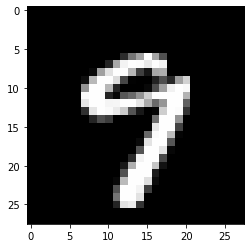

7

In [13]:
# Seeing our network in action

import matplotlib.pyplot as plt

# pick a sample to plot
sample = 50099
image = train_X[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

net = setInput(net, train_X[sample])
networkOutput = np.argmax(net.a[-1])
networkOutput